In [57]:
import numpy as np
from PIL import Image, ImageDraw

In [58]:
def padding(image_pixel):
    """make padding pixel

    Args:
        image_pixel (2 dimension array): image pixel matrix.

    Returns:
        modified_R: image pixel with padding
    """
    X = []
    for _ in range(len(image_pixel)):
        for _ in range(len(image_pixel[0])):
            Y = [0]
        X.append(Y)
    row_start = np.append(X, 
                          image_pixel, 
                          axis=1)
    row_end = np.append(row_start, 
                        X, 
                        axis=1)

    X = []
    for _ in range(len(row_end[0])):
        X.append(0)
    col_start = np.append([X], 
                          row_end, 
                          axis=0)
    col_end = np.append(col_start, 
                        [X], 
                        axis=0)

    return col_end

In [59]:
def convolution(image_pixel):
    """convolution image pixel

    Args:
        image_pixel (2 dimension array): image pixel matrix.

    Returns:
        convol_h (2 dimension array): convolution array
        convol_v (2 dimension array): convolution array
    """
    
    padding_R = padding(image_pixel) 
    sobel_x = np.array([[1,0,-1],
                        [2,0,-2],
                        [1,0,-1]])
    sobel_y = np.array([[1,2,1],
                        [0,0,0],
                        [-1,-2,-1]])
    convol_h = []
    convol_v = []
    
    for i in range(len(padding_R) - 2):
        convol_v_temp = []
        convol_h_temp = []
        
        for j in range(len(padding_R[0]) - 2):
            convol_h_temp.append(np.sum(padding_R[i:i+3:, j:j+3:] * sobel_x))
            convol_v_temp.append(np.sum(padding_R[i:i+3:, j:j+3:] * sobel_y))
        
        convol_h.append(convol_h_temp)
        convol_v.append(convol_v_temp)
    
    convol_h = np.array(convol_h)
    convol_v = np.array(convol_v)

    return convol_v, convol_h

In [60]:
def gaussian_blur(image_pixel):
    """gaussian blur

    Args:
        image_pixel (2 dimension array): image pixel matrix

    Returns:
        row (2 dimension array): image pixel matrix with gaussian blur
    """
    padding_R = padding(image_pixel)
    gaussian_h = np.array([1,2,1]) / 4 
    gaussian_v = np.array([1,2,1]).T / 4
    row = []

    for i in range(len(padding_R) - 2):
        col = []
        for j in range(len(padding_R[0]) - 2):
            col_temp = padding_R[i:i+3:, j:j+3:]@gaussian_h@gaussian_v
            col.append(col_temp)
        row.append(col)
    row = np.array(row)
    
    return row

In [61]:
def corner_detector(image_pixel):
    """corner detector

    Args:
        image_pixel (2 dimension array): image pixel matrix

    Returns:
        corner_coordinate ([x,y] list): corner with [x,y] coordinate
    """
    corner_coordinate = []
    
    convol_h, convol_v = convolution(image_pixel)
    gaussian_x = gaussian_blur(convol_h)
    gaussian_y = gaussian_blur(convol_v)
    
    dx = gaussian_x*gaussian_x
    dxy = gaussian_x*gaussian_y
    dy = gaussian_y*gaussian_y
    
    dx2 = gaussian_blur(dx)
    dxy2 = gaussian_blur(dxy)
    dy2 = gaussian_blur(dy)
    
    det = dx2 * dy2 - dxy2**2
    tr = (dx2 + dy2)**2
    
    rs = det - 0.06 * tr
    threshold = 700000000
    
    for i in range(len(rs)):
        for j in range(len(rs[0])):
            if rs[i][j] > threshold:
                corner_coordinate.append([i, j])

    corner_boundary = 20
                    
    for start in corner_coordinate :
        for end in corner_coordinate[:] :
            if (abs(end[0] - start[0]) < corner_boundary and 
                abs(end[1] - start[1]) < corner_boundary and 
                start != end) :
                corner_coordinate.remove(end)
                
    return corner_coordinate

In [62]:
def draw_corner(image_pixel, coordinate) :
    """draw corner in image

    Args:
        image_pixel (2 dimension array): image pixel matrix
        coordinate ([x,y] list): corner with [x,y] coordinate

    Returns:
        image (2 dimension array): image pixel with corner
    """
    re_image = Image.fromarray(image_pixel)
    draw = ImageDraw.Draw(re_image)
    for coor in coordinate :
        draw.ellipse((coor[1] - 5, coor[0] - 5, 
                      coor[1] + 5, coor[0] + 5),
                     outline='red')
        
    return re_image


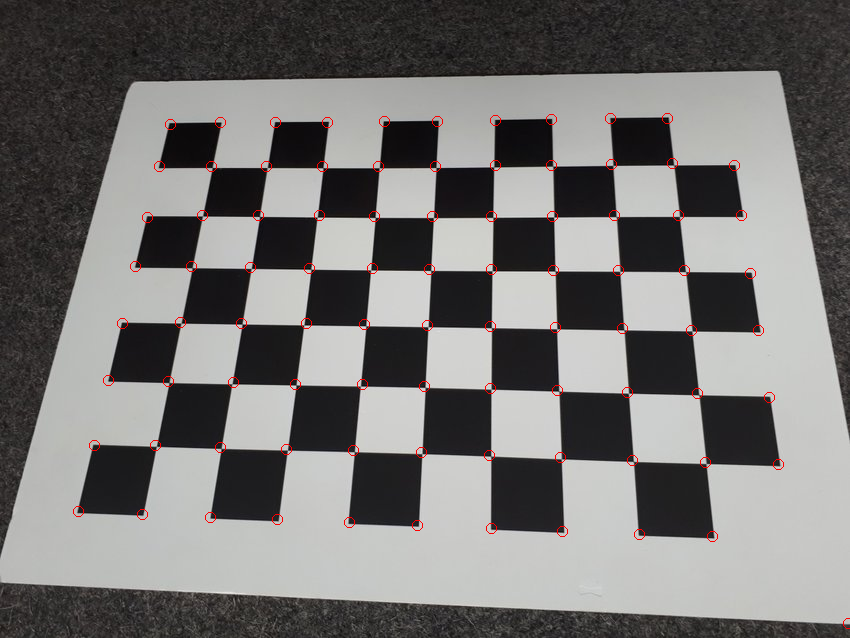

corner : 87


In [63]:
image_file = './data/image.png'

image_gray = Image.open(image_file).convert('L')
image_color = Image.open(image_file)
image_gray_pixel = np.array(image_gray)
image_color_pixel = np.array(image_color)

result_coordinate = corner_detector(image_gray_pixel)

result = draw_corner(image_color_pixel, result_coordinate)
result.show()

print(f'corner : {len(result_coordinate)}')